In [1]:
import numpy as np
from skimage import io


class ImageParser:
    def __init__(self):
        pass

    @staticmethod
    def read_png(path):
        image = io.imread(path, as_gray=True)
        return np.add(image < 0.4, image < 0.8, dtype=int)

    @staticmethod
    def write_png(image, path):
        fib = [153, 1, 2]
        myo = [226, 168, 88]

        out_image = np.zeros((image.shape[0], image.shape[1], 3),
                             dtype=np.uint8)
        out_image[image == 1] = myo
        out_image[image == 2] = fib
        io.imsave(path, out_image)

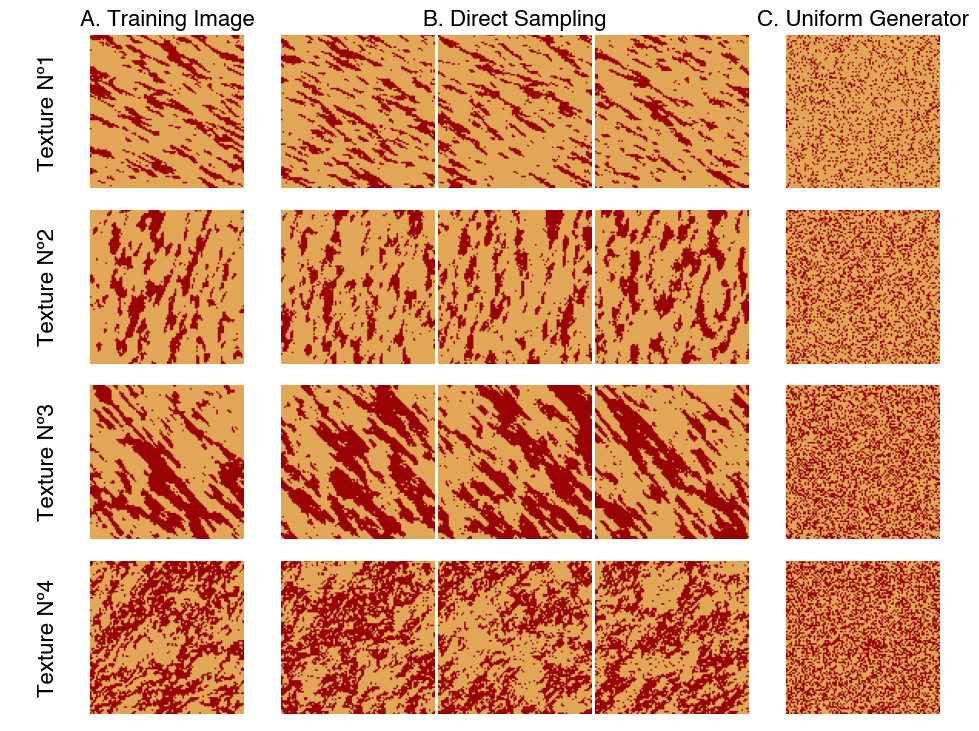

In [12]:
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

plt.rcParams['font.family'] = 'Helvetica'


tex_cmap = mcolors.LinearSegmentedColormap.from_list(
    'fibrosis', [(0, '#e2a858'),
                 (0.5, '#e2a858'),
                 (1, '#990102')])

path = Path('/Users/arstanbek/Projects/BiTis/data')

pattern_ids = [25, 2, 34, 5]

fig, axs = plt.subplots(nrows=4, ncols=8, figsize=(12, 9),
                        width_ratios=[0.5, 1, 0.2, 1, 1, 1, 0.2, 1],
                        gridspec_kw={'hspace': 0.05, 'wspace': 0.03})
for ax in axs.flatten():
    ax.axis('off')

for i, pattern_id in enumerate(pattern_ids):
    tr_filename = f'or_tex_{pattern_id}.png'
    tr_image = ImageParser.read_png(path.joinpath('training', tr_filename))
    tr_image = tr_image[:100, :100]
    tr_image[tr_image == 0] = 1

    axs[i, 1].imshow(tr_image.T, vmin=0, vmax=2, cmap=tex_cmap, origin='lower',
                     aspect='equal')

    img = []
    dens = []
    inds = np.random.choice(np.arange(100), 3, replace=False)

    for idx in inds:
        image = ImageParser.read_png(path.joinpath(f'simulated_{pattern_id}',
                                                   f'gen_tex_{pattern_id}_{idx}.png'))
        img.append(image[:100, :100])
        dens.append(np.mean(image == 2))
    
    uni_img = 1 + (np.random.random(img[-1].shape) <= dens[-1]).astype(int)
    axs[i, -1].imshow(uni_img.T, vmin=0, vmax=2, cmap=tex_cmap, origin='lower')

    for ax_id, im in zip([3, 4, 5], img):
        ax = axs[i, ax_id]
        ax.imshow(im.T, vmin=0, vmax=2, cmap=tex_cmap, origin='lower')

axs[0, 1].set_title('A. Training Image', fontsize=16)
axs[0, 4].set_title('B. Direct Sampling', fontsize=16)
axs[0, -1].set_title('C. Uniform Generator', fontsize=16)

for i, text in enumerate(['Texture Nº1', 'Texture Nº2',
                          'Texture Nº3', 'Texture Nº4']):
    axs[i, 0].text(0.5, 0.5, text, fontsize=16, ha='center', va='center',
                   transform=axs[i, 0].transAxes, rotation=90)

plt.show()

In [13]:
path_save = Path('/Users/arstanbek/Projects/FibrosisAnalysis/paperfigures/figures')
fig.savefig(path_save.joinpath('ds_generation_images.png'),
            dpi=300, bbox_inches='tight')

## Generation Quality

In [8]:
import pandas as pd
from bitis.texture.texture import Texture
from bitis.texture.properties import (
    PatternPropertiesBuilder,
    DistributionEllipseBuilder,
    PolarPlots,
    PointDensity
)


def calc_props(image, area_min=10, area_quantile=0.95):
    pattern_builder = PatternPropertiesBuilder(area_quantile=area_quantile,
                                               area_min=area_min)
    pattern_props = pattern_builder.build(image == 2)
    return pattern_props, pattern_builder.object_props


def read_image(path):
    image = ImageParser.read_png(path)
    image[image == 0] = 1
    return image[:100, :100]


def make_pattern_stats(path, pattern_ids, n_samples=100):
    
    all_pattern_props = []
    all_object_props = []
    for pattern_id in pattern_ids:
        for i in range(n_samples):
            image = read_image(path.joinpath(f'simulated_{pattern_id}',
                                             f'gen_tex_{pattern_id}_{i}.png'))
            
            pattern_props, object_props = calc_props(image)
            pattern_props['pattern_id'] = pattern_id

            object_props['pattern_id'] = pattern_id
            object_props['sample_id'] = i

            all_pattern_props.append(pattern_props)
            all_object_props.append(object_props)
    
    all_pattern_props = pd.concat(all_pattern_props).reset_index(drop=True)
    all_object_props = pd.concat(all_object_props).reset_index(drop=True)
    return all_pattern_props, all_object_props



data, objects_data = make_pattern_stats(path, [25, 2, 34, 5])

In [9]:
data.loc[data['orientation'] < 0, 'orientation'] = np.pi + \
    data[data['orientation'] < 0]['orientation']
data.loc[data['orientation'] > np.pi/2, 'orientation'] = - \
    np.pi + data[data['orientation'] > np.pi/2]['orientation']

data['deg_orientation'] = np.degrees(data['orientation'])

data.groupby('pattern_id').describe().T

pattern_id                           2           5           25          34
density               count  100.000000  100.000000  100.000000  100.000000
                      mean     0.258667    0.418056    0.206165    0.383636
                      std      0.021066    0.029331    0.018304    0.050740
                      min      0.199800    0.334400    0.157400    0.269800
                      25%      0.243350    0.399475    0.194875    0.347850
                      50%      0.259300    0.420350    0.203850    0.381900
                      75%      0.276025    0.437675    0.217125    0.423600
                      max      0.300300    0.507800    0.259200    0.489200
elongation            count  100.000000  100.000000  100.000000  100.000000
                      mean     2.641107    2.006752    3.949987    3.067594
                      std      0.296243    0.188804    0.352819    0.414315
                      min      2.145134    1.573246    3.185687    2.153236
                      25%      2.448839    1.867941    3.682025    2.796243
                      50%      2.607216    2.004942    3.958161    3.075552
                      75%      2.836802    2.112864    4.160073    3.316002
                      max      3.508849    2.525920    4.724516    4.345089
orientation           count  100.000000  100.000000  100.000000  100.000000
                      mean     1.378424    0.745051   -0.471821   -0.834621
                      std      0.055876    0.186235    0.042765    0.065601
                      min      1.246001    0.337471   -0.577988   -1.116956
                      25%      1.346505    0.652648   -0.506019   -0.873839
                      50%      1.378442    0.749530   -0.471018   -0.828006
                      75%      1.413021    0.858885   -0.440917   -0.801670
                      max      1.503077    1.326410   -0.373897   -0.686923
compactness           count  100.000000  100.000000  100.000000  100.000000
                      mean     0.134499    0.345428    0.098531    0.323630
                      std      0.021268    0.039473    0.016058    0.057726
                      min      0.083500    0.238400    0.063800    0.200400
                      25%      0.120550    0.324425    0.085725    0.275475
                      50%      0.132250    0.343000    0.095100    0.328400
                      75%      0.148925    0.370875    0.111175    0.363775
                      max      0.190700    0.473100    0.135900    0.442400
structural_anisotropy count  100.000000  100.000000  100.000000  100.000000
                      mean     5.582521    2.407768    9.279316    8.247135
                      std      1.418730    0.869293    2.105471    3.632433
                      min      3.301728    1.261292    5.880090    2.893340
                      25%      4.689476    1.919669    7.643855    6.129306
                      50%      5.341687    2.174618    9.114660    7.518590
                      75%      6.313135    2.558771   10.538592    9.132338
                      max     11.356534    6.536841   15.124142   20.162747
complexity            count  100.000000  100.000000  100.000000  100.000000
                      mean    73.498513  135.579315   72.333976   60.755969
                      std      5.309101    9.233061    7.032958    6.415314
                      min     60.048487  111.634113   52.368011   44.842738
                      25%     70.010325  128.394758   68.085232   56.321204
                      50%     73.520378  136.427249   72.396737   60.780771
                      75%     76.533399  141.983412   76.877566   64.494523
                      max     89.441709  154.504640   86.234970   75.774982
deg_orientation       count  100.000000  100.000000  100.000000  100.000000
                      mean    78.977884   42.688302  -27.033350  -47.820279
                      std      3.201447   10.670463    2.450268    3.758666
                      min     71.390600   19.335

In [14]:
# path = Path('/Users/arstanbek/Projects/BiTis/data/training')

tr_props = []
tr_objects = []

for pattern_id in pattern_ids:
    tr_image = read_image(path.joinpath('training', 
                                        f'or_tex_{pattern_id}.png'))
    pprops, oprops = calc_props(tr_image)
    pprops['pattern_id'] = pattern_id

    oprops['pattern_id'] = pattern_id
    oprops['sample_id'] = 0

    tr_props.append(pprops)
    tr_objects.append(oprops)

tr_data = pd.concat(tr_props).reset_index(drop=True)
tr_objects = pd.concat(tr_objects).reset_index(drop=True)
tr_data.loc[tr_data['orientation'] > 0.5 * np.pi, 'orientation'] -= np.pi

In [15]:
tr_data['deg_orientation'] = np.degrees(tr_data['orientation'])
tr_data.groupby('pattern_id').describe().T

pattern_id                          2           5          25         34
density               count   1.000000    1.000000   1.000000   1.000000
                      mean    0.235700    0.452000   0.251000   0.360300
                      std          NaN         NaN        NaN        NaN
                      min     0.235700    0.452000   0.251000   0.360300
                      25%     0.235700    0.452000   0.251000   0.360300
                      50%     0.235700    0.452000   0.251000   0.360300
                      75%     0.235700    0.452000   0.251000   0.360300
                      max     0.235700    0.452000   0.251000   0.360300
elongation            count   1.000000    1.000000   1.000000   1.000000
                      mean    2.629175    1.793300   4.342572   3.909836
                      std          NaN         NaN        NaN        NaN
                      min     2.629175    1.793300   4.342572   3.909836
                      25%     2.629175    1.793300   4.342572   3.909836
                      50%     2.629175    1.793300   4.342572   3.909836
                      75%     2.629175    1.793300   4.342572   3.909836
                      max     2.629175    1.793300   4.342572   3.909836
orientation           count   1.000000    1.000000   1.000000   1.000000
                      mean    1.331358    0.872939  -0.486476  -0.854912
                      std          NaN         NaN        NaN        NaN
                      min     1.331358    0.872939  -0.486476  -0.854912
                      25%     1.331358    0.872939  -0.486476  -0.854912
                      50%     1.331358    0.872939  -0.486476  -0.854912
                      75%     1.331358    0.872939  -0.486476  -0.854912
                      max     1.331358    0.872939  -0.486476  -0.854912
compactness           count   1.000000    1.000000   1.000000   1.000000
                      mean    0.113800    0.391400   0.126600   0.305100
                      std          NaN         NaN        NaN        NaN
                      min     0.113800    0.391400   0.126600   0.305100
                      25%     0.113800    0.391400   0.126600   0.305100
                      50%     0.113800    0.391400   0.126600   0.305100
                      75%     0.113800    0.391400   0.126600   0.305100
                      max     0.113800    0.391400   0.126600   0.305100
structural_anisotropy count   1.000000    1.000000   1.000000   1.000000
                      mean    4.413714    3.443814  11.004543  10.879331
                      std          NaN         NaN        NaN        NaN
                      min     4.413714    3.443814  11.004543  10.879331
                      25%     4.413714    3.443814  11.004543  10.879331
                      50%     4.413714    3.443814  11.004543  10.879331
                      75%     4.413714    3.443814  11.004543  10.879331
                      max     4.413714    3.443814  11.004543  10.879331
complexity            count   1.000000    1.000000   1.000000   1.000000
                      mean   66.161508  147.415642  86.257675  61.680524
                      std          NaN         NaN        NaN        NaN
                      min    66.161508  147.415642  86.257675  61.680524
                      25%    66.161508  147.415642  86.257675  61.680524
                      50%    66.161508  147.415642  86.257675  61.680524
                      75%    66.161508  147.415642  86.257675  61.680524
                      max    66.161508  147.415642  86.257675  61.680524
deg_orientation       count   1.000000    1.000000   1.000000   1.000000
                      mean   76.281196   50.015721 -27.873024 -48.982871
                      std          NaN         NaN        NaN        NaN
                      min    76.281196   50.015721 -27.873024 -48.982871
                      25%    76.281196   50.015721 -27.873024 -48.982871
                      50%    76.281196   50.015721 -27.873

In [16]:
uni_props = []
uni_objects = []

for pattern_id in pattern_ids:
    uni_image = read_image(path.joinpath('training', 
                                        f'or_tex_{pattern_id}.png'))
    dens = np.mean(uni_image == 2)
    uni_image = 1 + (np.random.random(uni_image.shape) <= dens).astype(int)
    pprops, oprops = calc_props(uni_image)
    pprops['pattern_id'] = pattern_id

    oprops['pattern_id'] = pattern_id
    oprops['sample_id'] = 0

    uni_props.append(pprops)
    uni_objects.append(oprops)

uni_data = pd.concat(uni_props).reset_index(drop=True)
uni_objects = pd.concat(uni_objects).reset_index(drop=True)
uni_data.loc[uni_data['orientation'] > 0.5 * np.pi, 'orientation'] -= np.pi

/Users/arstanbek/Projects/BiTis/bitis/texture/properties/distribution_ellipse.py:58: UserWarning: Not enough points to build the distribution ellipse.
  warnings.warn('Not enough points to build the distribution ellipse.')


In [17]:
uni_data['deg_orientation'] = 0
uni_data['orientation'] = 0
uni_data.groupby('pattern_id').describe().T

pattern_id                         2           5         25         34
density               count  1.000000    1.000000  1.000000   1.000000
                      mean   0.236600    0.460700  0.253000   0.357500
                      std         NaN         NaN       NaN        NaN
                      min    0.236600    0.460700  0.253000   0.357500
                      25%    0.236600    0.460700  0.253000   0.357500
                      50%    0.236600    0.460700  0.253000   0.357500
                      75%    0.236600    0.460700  0.253000   0.357500
                      max    0.236600    0.460700  0.253000   0.357500
elongation            count  1.000000    1.000000  1.000000   1.000000
                      mean   1.836295    1.947600  2.464371   1.875148
                      std         NaN         NaN       NaN        NaN
                      min    1.836295    1.947600  2.464371   1.875148
                      25%    1.836295    1.947600  2.464371   1.875148
                      50%    1.836295    1.947600  2.464371   1.875148
                      75%    1.836295    1.947600  2.464371   1.875148
                      max    1.836295    1.947600  2.464371   1.875148
orientation           count  1.000000    1.000000  1.000000   1.000000
                      mean   0.000000    0.000000  0.000000   0.000000
                      std         NaN         NaN       NaN        NaN
                      min    0.000000    0.000000  0.000000   0.000000
                      25%    0.000000    0.000000  0.000000   0.000000
                      50%    0.000000    0.000000  0.000000   0.000000
                      75%    0.000000    0.000000  0.000000   0.000000
                      max    0.000000    0.000000  0.000000   0.000000
compactness           count  1.000000    1.000000  1.000000   1.000000
                      mean   0.037900    0.163600  0.039600   0.099900
                      std         NaN         NaN       NaN        NaN
                      min    0.037900    0.163600  0.039600   0.099900
                      25%    0.037900    0.163600  0.039600   0.099900
                      50%    0.037900    0.163600  0.039600   0.099900
                      75%    0.037900    0.163600  0.039600   0.099900
                      max    0.037900    0.163600  0.039600   0.099900
structural_anisotropy count  0.000000    1.000000  1.000000   1.000000
                      mean        NaN    1.095703  2.568723   1.253350
                      std         NaN         NaN       NaN        NaN
                      min         NaN    1.095703  2.568723   1.253350
                      25%         NaN    1.095703  2.568723   1.253350
                      50%         NaN    1.095703  2.568723   1.253350
                      75%         NaN    1.095703  2.568723   1.253350
                      max         NaN    1.095703  2.568723   1.253350
complexity            count  1.000000    1.000000  1.000000   1.000000
                      mean   3.360187  156.083384  5.589151  64.276518
                      std         NaN         NaN       NaN        NaN
                      min    3.360187  156.083384  5.589151  64.276518
                      25%    3.360187  156.083384  5.589151  64.276518
                      50%    3.360187  156.083384  5.589151  64.276518
                      75%    3.360187  156.083384  5.589151  64.276518
                      max    3.360187  156.083384  5.589151  64.276518
deg_orientation       count  1.000000    1.000000  1.000000   1.000000
                      mean   0.000000    0.000000  0.000000   0.000000
                      std         NaN         NaN       NaN        NaN
                      min    0.000000    0.000000  0.000000   0.000000
                      25%    0.000000    0.000000  0.000000   0.000000
                      50%    0.000000    0.000000  0.000000   0.000000
                      75%    0.000000    0.000000  0.000000   0.000000
                      ma

In [40]:
def calc_ccdf(df):
    count = np.bincount(df['area'].values)
    area_bins = np.arange(1 + df['area'].max())

    area_bins = area_bins[1:]
    count = count[1:]
    ccdf = np.cumsum(count[::-1])[::-1] / np.sum(count)
    return area_bins, ccdf


def calc_area_cdf(df):
    count = np.bincount(df['area'].values)
    area_bins = np.arange(1 + df['area'].max())

    area_bins = area_bins[1:]
    count = count[1:]
    area = area_bins * count

    cdf = np.cumsum(area) / np.sum(area)
    return area_bins, cdf


def draw_area_cdf(ax, objects_props, label='', color='blue', alpha=1.0):
    area_bins, cdf = calc_area_cdf(objects_props)
    ax.plot(area_bins, cdf, label=label, color=color, alpha=alpha)
    ax.set_xlabel('Cluster Size', fontsize=16)
    ax.set_ylabel('Fibrotic Tissue', fontsize=16)
    ax.set_xscale('log')


def draw_ccdf(ax, objects_props, label='', color='blue', alpha=1.0, title=''):
    area_bins, ccdf = calc_ccdf(objects_props)
    ax.plot(area_bins, ccdf, label=label, color=color, alpha=alpha)
    ax.set_xlabel('Cluster Size', fontsize=16)
    # ax.set_ylabel('CCDF')
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.grid(True, which='both', alpha=0.5)
    ax.set_title(title, fontsize=16, loc='left')
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=14)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=14)

/var/folders/g1/w2ks7h117tx5hyrc51qld9v80000gn/T/ipykernel_3555/1238751698.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=14)
/var/folders/g1/w2ks7h117tx5hyrc51qld9v80000gn/T/ipykernel_3555/1238751698.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=14)
/var/folders/g1/w2ks7h117tx5hyrc51qld9v80000gn/T/ipykernel_3555/1238751698.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=14)
/var/folders/g1/w2ks7h117tx5hyrc51qld9v80000gn/T/ipykernel_3555/1238751698.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedL

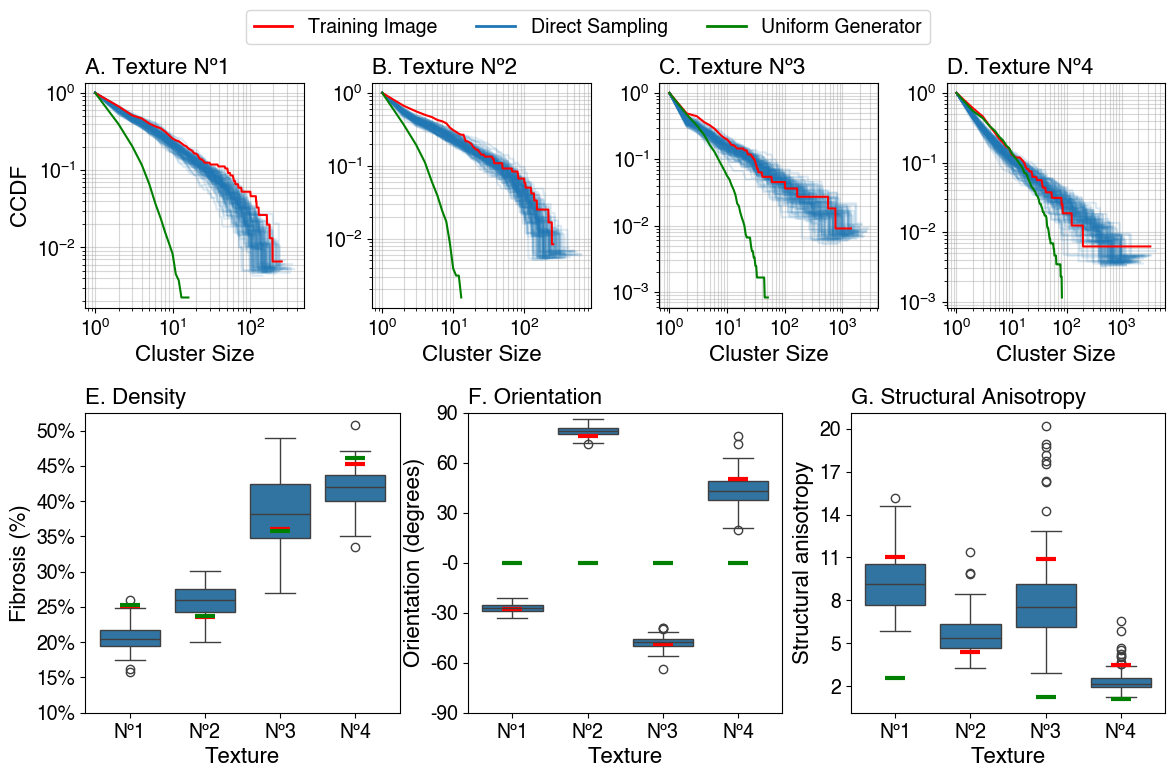

In [41]:
import seaborn as sns
import matplotlib as mpl


data.loc[data['orientation'] < 0, 'orientation'] = np.pi + \
    data[data['orientation'] < 0]['orientation']
data.loc[data['orientation'] > np.pi/2, 'orientation'] = - \
    np.pi + data[data['orientation'] > np.pi/2]['orientation']

# colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:purple']
colors = ['tab:blue', 'tab:blue', 'tab:blue', 'tab:blue']
axs_ids = ['a', 'b', 'c', 'd', 'e', 'f', 'g']
titles = ['A. Texture Nº1', 'B. Texture Nº2', 'C. Texture Nº3', 'D. Texture Nº4',
          'E. Density', 'F. Orientation', 'G. Structural Anisotropy']

fig, axs = plt.subplot_mosaic([['a', 'a', 'a',
                                'b', 'b', 'b',
                                'c', 'c', 'c',
                                'd', 'd', 'd'],
                               ['e', 'e', 'e', 'e',
                                'f', 'f', 'f', 'f',
                                'g', 'g', 'g', 'g'],
                               ], 
                                figsize=(12, 7.5),
                                height_ratios=[3, 4])

for i, prop in enumerate(['density', 'orientation', 'structural_anisotropy']):
    sns.boxplot(x='pattern_id', y=prop, data=data, order=pattern_ids, ax=axs[axs_ids[i+4]],
                palette=colors, linewidth=1, hue='pattern_id', legend=False)
    axs[axs_ids[i+4]].plot(tr_data[prop], marker='_', markersize=15, markeredgewidth=3,
                ls='', color='r', label='Training Image')
    axs[axs_ids[i+4]].plot(uni_data[prop], marker='_', markersize=15, markeredgewidth=3,
                ls='', color='g', label='Uniform Generator')
    axs[axs_ids[i+4]].set_xticks(np.arange(len(pattern_ids)))
    axs[axs_ids[i+4]].set_xticklabels([f'Nº{i}' for i in range(1, 1 + len(pattern_ids))],
                           fontsize=14)
    axs[axs_ids[i+4]].set_xlabel('Texture', fontsize=16)
    axs[axs_ids[i+4]].set_title(titles[i + 4], fontsize=16, loc='left')

legend_lines = [mpl.lines.Line2D([0], [0], color='red', lw=2, label='Training Image'),
                mpl.lines.Line2D([0], [0], color='tab:blue', lw=2, label='Direct Sampling'),
                mpl.lines.Line2D([0], [0], color='g', lw=2, label='Uniform Generator')]

# for subplot in ['a', 'b', 'c', 'd']:
#     axs[subplot].legend(handles=legend_lines, loc='lower left', fontsize=11)

# axs['e'].legend(handles=legend_lines, loc='upper left', fontsize=11)
# axs['f'].legend(handles=legend_lines, loc='lower left', fontsize=11)
# axs['g'].legend(handles=legend_lines, loc='upper left', fontsize=11)

axs['e'].set_yticks(np.arange(0.1, 0.55, 0.05))
axs['e'].set_yticklabels(axs['e'].get_yticks(), fontsize=14)
axs['e'].set_ylabel('Fibrosis (%)', fontsize=16)
axs['e'].yaxis.set_major_formatter(
    mpl.ticker.PercentFormatter(xmax=1, decimals=0))

axs['f'].set_ylim(-np.pi/2, np.pi/2)
axs['f'].set_yticks(np.arange(-np.pi/2, 1.1 * np.pi/2, np.pi/6))
axs['f'].set_yticklabels(axs['f'].get_yticks(), fontsize=14)
axs['f'].set_ylabel('Orientation (degrees)', fontsize=16)
axs['f'].yaxis.set_major_formatter(
    mpl.ticker.FuncFormatter(lambda x, _: f'{np.rad2deg(x):.0f}'))

axs['g'].set_yticks(np.arange(2, 21, 3))
axs['g'].set_yticklabels(axs['g'].get_yticks(), fontsize=14)
axs['g'].set_ylabel('Structural anisotropy', fontsize=16)
axs['g'].yaxis.set_major_formatter(
    mpl.ticker.FuncFormatter(lambda x, _: f'{x:.0f}'))

for i, pattern_id in enumerate(pattern_ids):
    for j in range(100):
        draw_ccdf(axs[axs_ids[i]], objects_data[(objects_data['pattern_id'] == pattern_id) &
                                            (objects_data['sample_id'] == j)],
                                            color=colors[i], alpha=0.15)
    draw_ccdf(axs[axs_ids[i]], tr_objects[tr_objects['pattern_id'] == pattern_id],
              label='Training Image', color='red', alpha=1.0, title=titles[i])
    draw_ccdf(axs[axs_ids[i]], uni_objects[uni_objects['pattern_id'] == pattern_id],
              label='Uniform Generator', color='g', alpha=1.0, title=titles[i])
    # axs[axs_ids[i]].legend(loc='lower right', fontsize=11)
axs['a'].set_ylabel('CCDF', fontsize=16)

# plt.tight_layout()

fig.legend(handles=legend_lines,
           loc='upper center', ncol=3, prop={'size': 14})

plt.subplots_adjust(top=0.89, 
                    bottom=0.05, 
                    left=0.05, 
                    right=0.95, 
                    hspace=0.4,
                    wspace=2.5)
plt.show()

In [42]:
path_save = Path('/Users/arstanbek/Projects/FibrosisAnalysis/paperfigures/figures')
fig.savefig(path_save.joinpath('ds_generation_quality.png'),
            dpi=300, bbox_inches='tight')